### Main file

In [15]:
from tools.helpers import *
from tools.srbm import *
from tools.parameters_main import *
from brian2 import *
from brian2tools import *
import numpy as np
import matplotlib.pyplot as plt
import datetime

date_str = str(datetime.datetime.now())[0:10]
date_time_str = str(datetime.datetime.now())[0:10]+"_"+str(datetime.datetime.now())[11:16]

In [16]:
Id = create_Id()
W, b_v, b_c, b_h = create_rbm_parameters()
mnist_data = load_mnist_data(min_p = .00001, max_p = .98, binary = True, seed=0)
loc = main(W, b_v, b_c, b_h, Id =create_Id(), monitors = True, mnist_data=mnist_data)
locals().update(loc)

Creating equation
Creating Population


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


Train accuracy: 0.125
Test accuracy: 0.137
Train accuracy: 0.08
Test accuracy: 0.083
Train accuracy: 0.17
Test accuracy: 0.165
Train accuracy: 0.155
Test accuracy: 0.173
Train accuracy: 0.16
Test accuracy: 0.165
Train accuracy: 0.16
Test accuracy: 0.208
Train accuracy: 0.095
Test accuracy: 0.115
Train accuracy: 0.16
Test accuracy: 0.18
Train accuracy: 0.15
Test accuracy: 0.169
Train accuracy: 0.205
Test accuracy: 0.244
Train accuracy: 0.265
Test accuracy: 0.296
Train accuracy: 0.185
Test accuracy: 0.198
Train accuracy: 0.17
Test accuracy: 0.171
Train accuracy: 0.19
Test accuracy: 0.2
Train accuracy: 0.13
Test accuracy: 0.141
Train accuracy: 0.235
Test accuracy: 0.259
Train accuracy: 0.205
Test accuracy: 0.209
Train accuracy: 0.185
Test accuracy: 0.183
Train accuracy: 0.17
Test accuracy: 0.192
Train accuracy: 0.23
Test accuracy: 0.221
Train accuracy: 0.16
Test accuracy: 0.165
Train accuracy: 0.1
Test accuracy: 0.109
Train accuracy: 0.23
Test accuracy: 0.199
Train accuracy: 0.23
Test acc

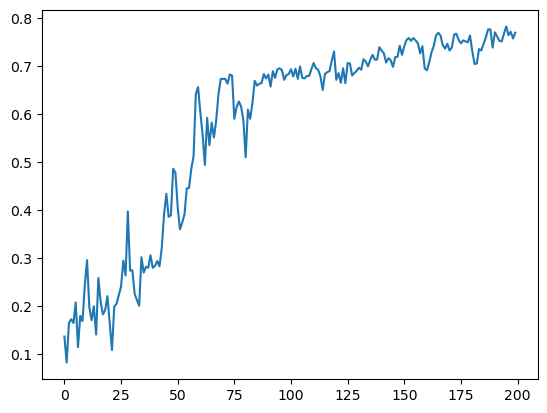

In [17]:
plot(res_hist_test)
plt.show()

In [18]:
# Why does beta get replaced by the numpy function??

beta = 2.04371561e+09

W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta
Wvh=W[:N_v,:]
Wch=W[N_v:,:]
mBv = np.array(Sbv.w)*beta*tau_rec*bias_input_rate
mBh = np.array(Sbh.w)*beta*tau_rec*bias_input_rate
b_c = mBv[N_v:(N_v+N_c)]
b_v = mBv[:N_v]
b_h = mBh
mB = np.concatenate([mBv,mBh])

In [19]:
def save_matrices(W, Wvh, Wch, mBv, mBh, b_c, b_v, b_h, mB, date_str, date_time_str):
    mypath = "output/"+date_str+"/"+date_time_str[11:16]
    if not os.path.isdir(mypath):
        os.makedirs(mypath)

    W.dump(mypath+"/W.dat")
    Wvh.dump(mypath+"/Wvh.dat")
    Wch.dump(mypath+"/Wch.dat")
    mBv.dump(mypath+"/mBv.dat")
    mBh.dump(mypath+"/mBh.dat")
    b_c.dump(mypath+"/b_c.dat")
    b_v.dump(mypath+"/b_v.dat")
    b_h.dump(mypath+"/b_h.dat")
    mB.dump(mypath+"/mB.dat")

    print("Matrices saved to output/"+mypath)


In [20]:
save_matrices(W, Wvh, Wch, mBv, mBh, b_c, b_v, b_h, mB, date_str, date_time_str)

Matrices saved to output/output/2023-04-13/18:57
